# Project: Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

#### load data
We can save the cleaned data for future use. Every time we read a csv file, we can reduce its memery usage.

In [2]:
# load data
def load_input_data(load_raw, is_debug):
        
    if load_raw:
        if is_debug:
            azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', nrows=40000)
            customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', nrows=8000)
        else:
            azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
            customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
    else:
        azdias = pd.read_csv('/home/workspace/data/Azdias_cleaned.csv')
        customers = pd.read_csv('/home/workspace/data/Customers_cleaned.csv')   
        
    return reduce_mem_usage(azdias), reduce_mem_usage(customers)


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
azdias, customers = load_input_data(load_raw=True, is_debug=True)


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Mem. usage decreased to 25.90 Mb (76.8% reduction)
Mem. usage decreased to  5.31 Mb (76.4% reduction)


In [4]:
attribute_values = pd.read_excel('/home/workspace/DIAS Attributes - Values 2017.xlsx',header=1)
attribute_description = pd.read_excel('/home/workspace/DIAS Information Levels - Attributes 2017.xlsx',header=1)

In [5]:
print("Azdias Shape: ", azdias.shape)
print("Customers Shape: ", customers.shape)

Azdias Shape:  (40000, 366)
Customers Shape:  (8000, 369)


Have a look ot Azdias and Customers data:

In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## Part 1: Data Preparation

### 1.1 Handle Missing Data

In [8]:
# replacing  unknows/nul values from each columnsafter reading ducomentation of data
# fill missing values with -1 indicating unknown as in the description.

azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'], -1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'], -1)

azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)

azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)

azdias[['CAMEO_DEU_2015','OST_WEST_KZ']] = azdias[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers[['CAMEO_DEU_2015','OST_WEST_KZ']] = customers[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

# categorical 
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
customers['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)



We can find from previous output that certain columns of data include NaNs.

Text(0,0.5,'Percent of NaNs for Given Column')

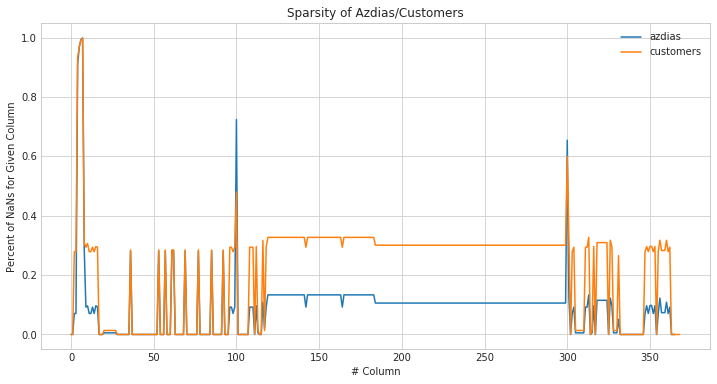

In [9]:
# check sparsity of data

def check_sparsity_columns(df):
    sparsity = df.isna().mean() 
    return sparsity

azdias_sparsity = check_sparsity_columns(azdias)
customers_sparsity = check_sparsity_columns(customers)

plt.figure(figsize=(12,6))
plt.title('Sparsity of Azdias/Customers')
plt.plot(azdias_sparsity.values, label='azdias')
plt.plot(customers_sparsity.values, label='customers')
plt.legend()
plt.xlabel('# Column')
plt.ylabel('Percent of NaNs for Given Column')

In [10]:
# Remove columns that has large percentage of NaNs

remove_threshold = 0.6
remove_azdias_columns = azdias_sparsity[(azdias_sparsity>remove_threshold) | (customers_sparsity>remove_threshold)].index
remove_customers_columns = customers_sparsity[(azdias_sparsity>remove_threshold) | (customers_sparsity>remove_threshold)].index

print('Remove azdias columns due to sparsity: {}'.format(remove_azdias_columns))
print('Remove customers columns due to sparsity: {}'.format(remove_customers_columns))

azdias_c = azdias.drop(columns=remove_azdias_columns)
customers_c = customers.drop(columns=remove_customers_columns)


Remove azdias columns due to sparsity: Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')
Remove customers columns due to sparsity: Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')


In [11]:
# Remove rows that has large percentage of NaNs

def check_sparsity_rows(df, remove_threshold=0.6):
    remove_row = list(df[df.isnull().mean(axis=1) > remove_threshold].index)
    keep_row = list(df[df.isnull().mean(axis=1) <= remove_threshold].index)

    print('Percent of Removed Rows: {}'.format(len(remove_row)/df.shape[0]))    
    
    return keep_row
print('Remove NaN Rows for Population')
azdias_c = azdias_c.loc[check_sparsity_rows(azdias_c), :]
print('Remove NaN Rows for Customers')
customers_c = customers_c.loc[check_sparsity_rows(customers_c), :]


Remove NaN Rows for Azdias
Percent of Removed Rows: 0.079025
Remove NaN Rows for Customers
Percent of Removed Rows: 0.280125


In [12]:
# remove 3 other columns in customers to match columns with azdias
customers_c = customers_c.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'])

In [13]:
# fill na values

def find_numeric_categorical_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_cols = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in numerics]
    categorical_columns = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object']]
    return numeric_cols, categorical_columns
    

def fill_nan_with_median(df, cols):    
    for col in cols:
        median_value = df[col].median(skipna=True)
        df[col] =  df[col].fillna(median_value)
    return df

def fill_nan_with_mode(df, cols):    
    for col in cols:
        mode_value = df[col].mode()[0]
        df[col] =  df[col].fillna(mode_value)
    return df


# get numeric and categorical columns
azdias_numeric_columns, azdias_categorical_columns = find_numeric_categorical_columns(azdias_c)
customers_numeric_columns, customers_categorical_columns = find_numeric_categorical_columns(customers_c)


# for numeric columns, replace Nan with median
azdias_c = fill_nan_with_median(azdias_c, azdias_numeric_columns)
customers_c = fill_nan_with_median(customers_c, customers_numeric_columns)


# for categorical columns, replace Nan with mode
azdias_c = fill_nan_with_mode(azdias_c, azdias_categorical_columns)
customers_c = fill_nan_with_mode(customers_c, customers_categorical_columns)

### 1.2 Handle Dummy Variables

In [14]:
# create dummies variables

cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']

# dummy variable with too many categories
cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']

azdias_c = azdias_c.drop(cols_to_drop, axis=1)
customers_c = customers_c.drop(cols_to_drop, axis=1)

for col in azdias_categorical_columns:
    if col in azdias_c.columns:
#         azdias_c[col] = pd.get_dummies(azdias_c, columns=[col])
        class_le = LabelEncoder()
        azdias_c[col] = class_le.fit_transform(azdias_c[col].values)
    
for col in customers_categorical_columns:
    if col in customers_c.columns:
#         customers_c[col] = pd.get_dummies(customers_c, columns=[col])
        class_le = LabelEncoder()
        customers_c[col] = class_le.fit_transform(customers_c[col].values)



In [15]:
print("Azdias Shape: ", azdias_c.shape)
print("Customers Shape: ", customers_c.shape)


Azdias Shape:  (36839, 353)
Customers Shape:  (5759, 353)


### 1.3 Feature Scaling

In [16]:
# Apply feature scaling to the general population demographics data.

scaler = MinMaxScaler()
azdias_c = pd.DataFrame(scaler.fit_transform(azdias_c), columns=azdias_c.columns)
azdias_c = pd.DataFrame(scaler.transform(customers_c), columns=customers_c.columns)

In [17]:
# save clean data
azdias_c.to_csv('Azdias_cleaned.csv')
customers_c.to_csv('Customers_cleaned.csv')   

In [18]:
def clean_data(df, drop_rows=True):
    keep_rows = None
    
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'], -1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']] = df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
    if df['OST_WEST_KZ'].dtype != 'int64':
        df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    
    # remove columns that has large percentage of NaNs
    df_sparsity = check_sparsity_columns(df)    
    remove_threshold = 0.6
    remove_columns = df_sparsity[(df_sparsity>remove_threshold)].index
    df = df.drop(columns=remove_columns)
    
    if drop_rows:
        # remove rows that has large percentage of NaNs   
        print('Remove NaN Rows:')
        keep_rows = check_sparsity_rows(df)
        df = df.loc[keep_rows, :]    
  

    # get numeric and categorical columns
    numeric_columns, categorical_columns = find_numeric_categorical_columns(df)
    
    # for numeric columns, replace Nan with median
    df = fill_nan_with_median(df, numeric_columns)

    # for categorical columns, replace Nan with mode
    df = fill_nan_with_mode(df, categorical_columns)
    
    
    # handle dummy variable
    cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                     'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                     'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']

    # dummy variable with too many categories
    cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                    'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']

    df = df.drop(cols_to_drop, axis=1)

    for col in categorical_columns:
        if col in df.columns:
#             print(f'labelencoder: {col}')
            class_le = LabelEncoder()
            df[col] = class_le.fit_transform(df[col].values)

    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns).copy()
    del df['LNR']

    return df, keep_rows

## Part 2: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 2.1: Dimension Reduction Using Principal Component Analysis

We have many components (300 features) and a lot of features are large correlations

Therefore, we need to use PCA to minimize the redundency of the features.

100 has a cumulative explained variane of: 0.8115899235585103


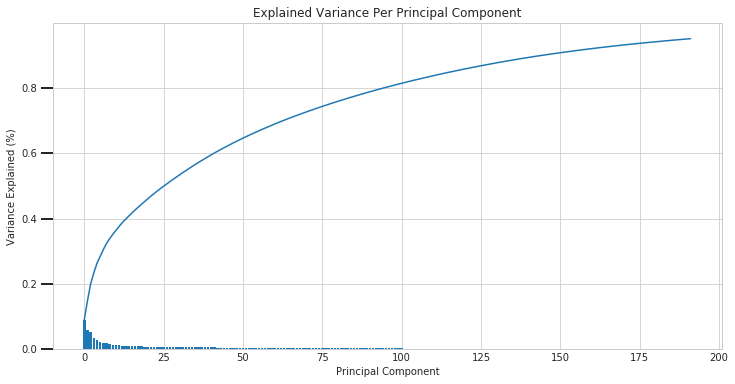

In [19]:
from sklearn.decomposition import PCA
def scree_plot(pca_estimator):

    num_components = len(pca_estimator.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca_estimator.explained_variance_ratio_
 
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca = PCA(n_components = .95)
azd_pca = pca.fit_transform(azdias_c)

scree_plot(pca)

n_components = 100
print(f'{n_components} has a cumulative explained variane of: {sum(pca.explained_variance_ratio_[:n_components])}')

The plots above show that the explained variance plateaus a couple of times. The first and sharpest drop-off is around 15 components. At 15 components around 42 % of the total variance is explained. After this we can observe two other, but not as steep drop-offs around 100 and 200 components. At 100 components 86 % of the total variance is explained and at 150 90 %. With each consecutive component less and less variance is explained which means that after a while the amount of additional explained variance probably is not worth the extra number of components. With that said 100 components could be considered a good middle point.

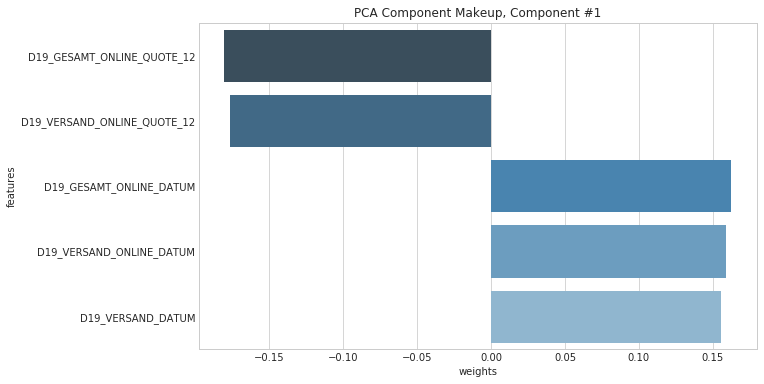

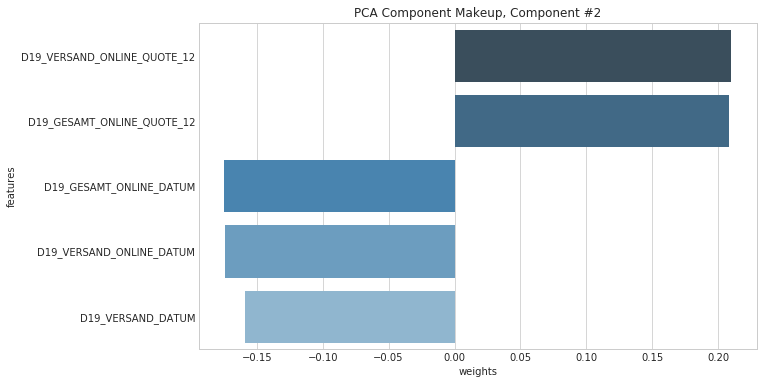

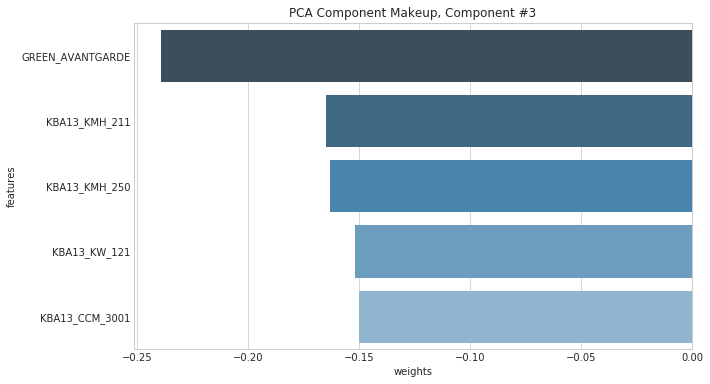

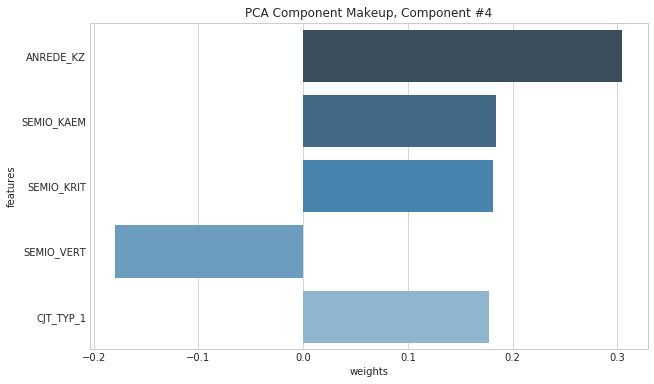

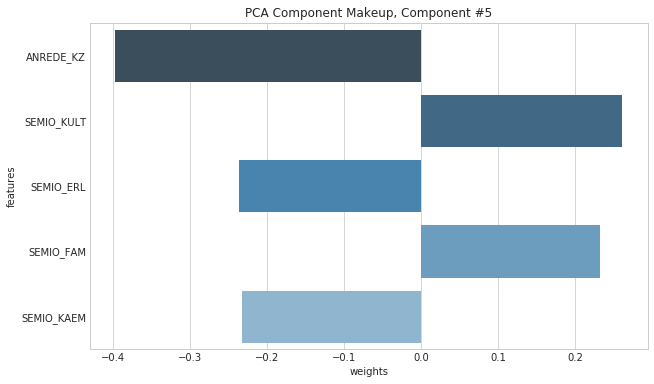

In [20]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = component_num - 1

    # get the list of weights from a row in v, dataframe
    v_1_row = v[row_idx]
    v_1 = np.squeeze(v_1_row)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

for num in range (1,6):
    display_component(pca.components_, azdias_c.columns.values, component_num=num, n_weights=5)

In [41]:
# get shrink features
azdias_shrink = pd.DataFrame(pca.transform(azdias_c))
print(f'Shrinked Population Shape: {azdias_shrink.shape}')
customers_shrink = pd.DataFrame(pca.transform(customers_c))
print(f'Shrinked Customers Shape: {customers_shrink.shape}')


Shrinked Population Shape: (5759, 192)
Shrinked Customers Shape: (5759, 192)


### 2.2 Clustering Model

**benchmark model: K-Means**

Text(0,0.5,'silhouette score')

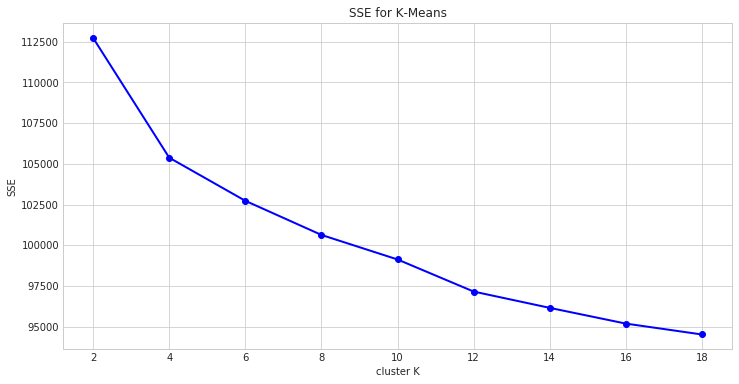

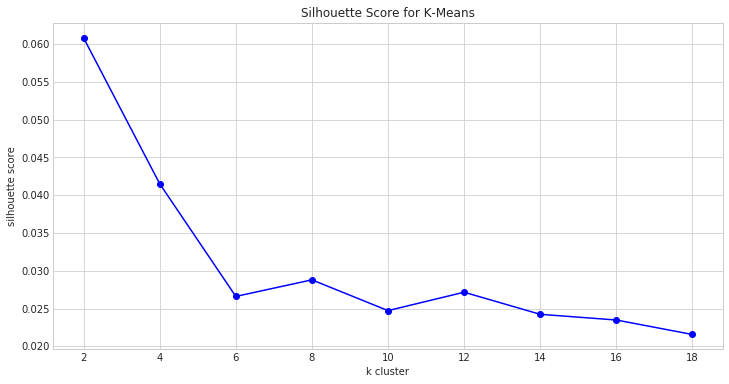

In [22]:
# K-means

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

k_lst = range(2, 20, 2)
kmeans_by_k_azdias = [KMeans(n_clusters=k, random_state=0).fit(azdias_shrink) for k in k_lst]

SSE = [model.inertia_ for model in kmeans_by_k_azdias]
plt.figure(figsize=(12, 6))
plt.plot(k_lst, SSE, 'bo-', linewidth=2)
plt.title('SSE for K-Means')
plt.xlabel('cluster K')
plt.ylabel('SSE');


silhouette_scores = [silhouette_score(azdias_shrink, model.labels_, sample_size=5000) for model in kmeans_by_k_azdias]

plt.figure(figsize=(12, 6))
plt.plot(k_lst, silhouette_scores, 'bo-')
plt.title('Silhouette Score for K-Means')
plt.xlabel('k cluster')
plt.ylabel('silhouette score')

choose k=10

**other model: MiniBatchKmeans**

Text(0,0.5,'silhouette score')

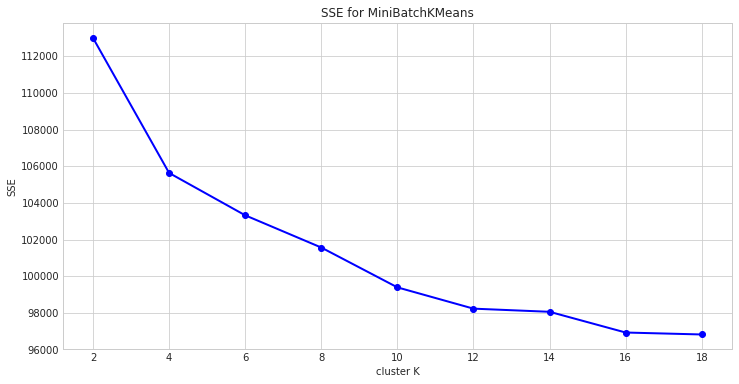

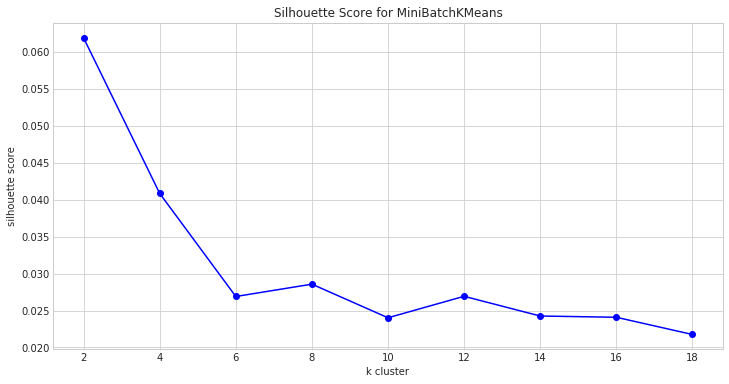

In [23]:
k_lst = range(2, 20, 2)
minibatch_by_k_azdias = [MiniBatchKMeans(n_clusters=k, random_state=0).fit(azdias_shrink) for k in k_lst]

SSE = [model.inertia_ for model in minibatch_by_k_azdias]
plt.figure(figsize=(12, 6))
plt.plot(k_lst, SSE, 'bo-', linewidth=2)
plt.title('SSE for MiniBatchKMeans')
plt.xlabel('cluster K')
plt.ylabel('SSE');


silhouette_scores = [silhouette_score(azdias_shrink, model.labels_, sample_size=5000) for model in kmeans_by_k_azdias]

plt.figure(figsize=(12, 6))
plt.plot(k_lst, silhouette_scores, 'bo-')
plt.title('Silhouette Score for MiniBatchKMeans')
plt.xlabel('k cluster')
plt.ylabel('silhouette score')

choose K=4

**Compare Customer Data to Demographics Data**

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

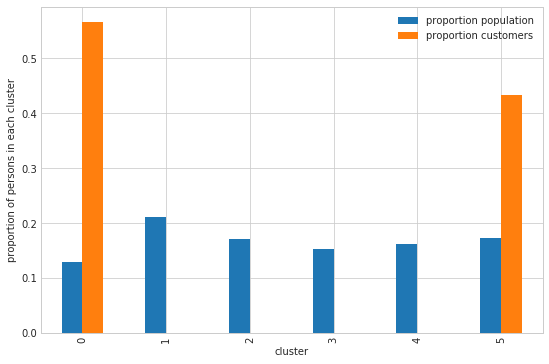

In [24]:
# predict
choose_model = minibatch_by_k_azdias[2]
predict_customers = choose_model.predict(customers_shrink)

population_ratio = []
customers_ratio = []
x = [i for i in range(6)]

for i in range(6):
    population_ratio.append((choose_model.labels_ == i).sum()/len(choose_model.labels_))
    customers_ratio.append((predict_customers == i).sum()/len(predict_customers))


df = pd.DataFrame({'cluster' : x, 'proportion population' : population_ratio, 'proportion customers':customers_ratio})
df.plot(x='cluster', y = ['proportion population', 'proportion customers'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

It is clear that customers are almost belong to cluster 4 and 5.

This means the people in cluster 4 and 5 have certain set of features in the principal components which drives that people belonging to this clusters are more likely to be our customers.

After analyzing the components of cluster 4 and 5, we can get an idea of the common traits of customers.

## Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


In [26]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
mailout_train.shape

(42962, 367)

In [28]:
# data processing

# seperate X, y
y = mailout_train['RESPONSE']
X = mailout_train.drop('RESPONSE', axis=1)

# data clearning for X
X, keep_rows = clean_data(X)
y = y.iloc[keep_rows]

print(X.shape)
print(y.shape)

Remove NaN Rows:
Percent of Removed Rows: 0.16724081746659838
(35777, 354)
(35777,)


Text(0.5,1,'Distribution of Response')

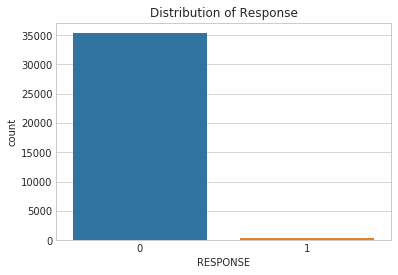

In [29]:
# imbalance of y

sns.countplot(y).set_title("Distribution of Response")

In [30]:
# split train test
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25043, 354)
(10734, 354)
(25043,)
(10734,)


In [33]:
def classifier_test(clf, param_grid, X=X, y=y):
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    print(grid.best_estimator_)
    print(f'train set AUC: {grid.best_score_}')    
    
    return grid.best_estimator_

def plot_roc_curve_(clf, X, y):  
    probs = clf.predict_proba(X)  
    probs = probs[:, 1]

    fpr, tpr, thresholds = roc_curve(y, probs)
    auc_a = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % auc_a )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
train set AUC: 0.6469209960897228


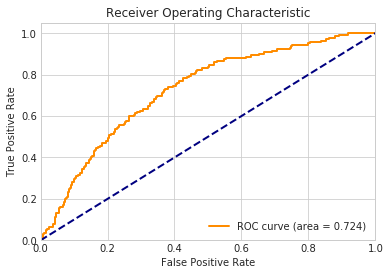

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train set AUC: 0.6858128020852071


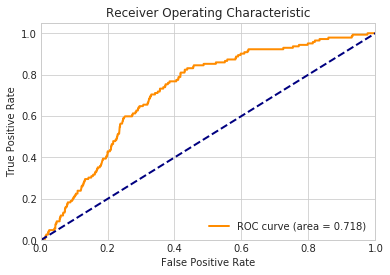

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)
train set AUC: 0.7648822988371822


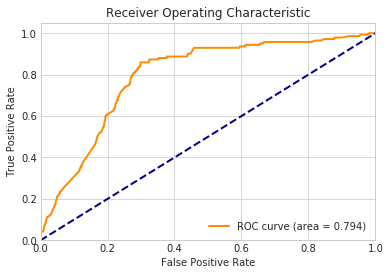

In [34]:
clfs = [
    (LogisticRegression(), 
     {}),
    (RandomForestClassifier(), 
     {'max_depth': [2, 3, 4]}),
    (AdaBoostClassifier(), 
     {'algorithm': ['SAMME.R'], 'learning_rate': [0.01, 0.1],'n_estimators': [20, 50]}),
#     (GradientBoostingClassifier(),  
#      {'criterion':['friedman_mse'], 'learning_rate': [0.01, 0.1, 1.0], 'n_estimators': [20, 50, 100]})    
]

for clf, parameters in clfs:
    best_model = classifier_test(clf, parameters, X=X_train, y=y_train)
    plot_roc_curve_(best_model, X=X_test, y=y_test)

We found that the AdaBoostClassifierClassifier has a higher ROC_AUC=0.768. While learning rate=0.1, n_estimators=50.

## Part 4: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [35]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
mailout_test.shape

(42833, 366)

In [37]:
mailout_test_c, _ = clean_data(mailout_test, drop_rows=False)
mailout_test_c.shape

(42833, 354)

In [38]:
# fit model
clf = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)
clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)

In [39]:
response = clf.predict_proba(mailout_test_c)

print(response)

[[ 0.67089466  0.32910534]
 [ 0.67089466  0.32910534]
 [ 0.75525334  0.24474666]
 ..., 
 [ 0.67267357  0.32732643]
 [ 0.68329204  0.31670796]
 [ 0.67267357  0.32732643]]


In [40]:
# submit
kaggle = pd.DataFrame({'LNR': mailout_test['LNR'], 'RESPONSE': response[:,1]})
kaggle.to_csv('kaggle_submit.csv', index = False)
kaggle.head()

,LNR,RESPONSE
0,1754,0.329105
1,1770,0.329105
2,1465,0.244747
3,1470,0.250679
4,1478,0.252324
